# Processing Videos

In [1]:
from glob import glob
import os
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity
import imutils
import numpy as np
from math import log10
import copy
import h5py
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

### Helper Funtions

In [2]:
def file_path(folder_path,mode = 'avi',recursive=False):
        return os.path.join(folder_path,'**','*.'+mode)


def dict_key_sort(df):
    for i in df:
        df[i].sort()
    return df

def save_frame(read_path):
    
    path = os.path.join(read_path)
    print(path)
    filename = os.path.basename(path)
    print(filename)
    write_path = os.path.join('/'.join(read_path.split('/')[:-3]),'Frame',read_path.split('/')[-2],filename.replace('.','_').replace('-','_'))
    print(write_path)
    os.makedirs(write_path, exist_ok=True)
    
    video = cv2.VideoCapture(path)
    counter=0
    while(video.isOpened()):
        ret, frame = video.read()
        if ret==True:
            
            cv2.imwrite(os.path.join(write_path,"frame_%d.jpg" % counter), frame)  
            counter+=1
            ret, frame = video.read()
            if cv2.waitKey(20) & 0xFF == ord('q'):
                break
        else:
            break   
    
    print(f'Total Frames written for video {filename} are {counter} in folder {write_path}')
    video.release()

### Initialised Variables

In [3]:
fake_videos_path = 'Dataset/DeepfakeTIMIT/higher_quality'
original_videos_path = 'Dataset/VidTIMIT/VidTIMIT'

In [4]:
fake_videos = glob(file_path(fake_videos_path))
original_videos = glob(file_path(original_videos_path))

In [5]:
DeepfakeTIMIT = {i.split('/')[-2]:[j for j in glob(file_path(os.path.join(fake_videos_path,i.split('/')[-2])),recursive=True)] for i in fake_videos}
VidTIMIT      = {i.split('/')[-2]:[j for j in glob(file_path(os.path.join(original_videos_path,i.split('/')[-2])),recursive=True)] for i in fake_videos}

In [6]:

DeepfakeTIMIT = dict_key_sort(DeepfakeTIMIT)
VidTIMIT = dict_key_sort(VidTIMIT)


In [7]:
VidTIMIT['fadg0']

['Dataset/VidTIMIT/VidTIMIT/fadg0/sa1.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sa2.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/si1279.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/si1909.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/si649.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sx109.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sx19.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sx199.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sx289.avi',
 'Dataset/VidTIMIT/VidTIMIT/fadg0/sx379.avi']

In [8]:
DeepfakeTIMIT['fadg0']

['Dataset/DeepfakeTIMIT/higher_quality/fadg0/sa1-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sa2-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/si1279-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/si1909-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/si649-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sx109-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sx19-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sx199-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sx289-video-fram1.avi',
 'Dataset/DeepfakeTIMIT/higher_quality/fadg0/sx379-video-fram1.avi']

### Saving Frames for single video

In [9]:


fake_file_path =DeepfakeTIMIT['fadg0'][0]
original_file_path = VidTIMIT['fadg0'][0]

save_frame(fake_file_path)
save_frame(original_file_path)

Dataset/DeepfakeTIMIT/higher_quality/fadg0/sa1-video-fram1.avi
sa1-video-fram1.avi
Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi
Total Frames written for video sa1-video-fram1.avi are 60 in folder Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi
Dataset/VidTIMIT/VidTIMIT/fadg0/sa1.avi
sa1.avi
Dataset/VidTIMIT/Frame/fadg0/sa1_avi
Total Frames written for video sa1.avi are 60 in folder Dataset/VidTIMIT/Frame/fadg0/sa1_avi


### Saving Frames for all the videos in their respective folders (There were diffrence of 14 frames in total from deepfake and videotmt frames)

In [ ]:
for i in DeepfakeTIMIT:
    for j in DeepfakeTIMIT[i]:
        save_frame(j)
        

In [ ]:
for i in VidTIMIT:
    for j in VidTIMIT[i]:
        save_frame(j)

### Calculating diffrence of 2 frames for their original and fake counterparts

In [9]:
fake_image = cv2.imread("Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg")
original_image = cv2.imread("Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg")

fake_image = cv2.cvtColor(fake_image, cv2.COLOR_BGR2RGB)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

fake_image_ = fake_image.copy() 
original_image_ = original_image.copy() 

difference_ = cv2.subtract(original_image,fake_image)

difference = difference_.copy()
cv2.imwrite('difference.png', difference)



# color the mask
Gray_difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Gray_difference, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [0, 255, 255]

# add the mask to the images to make the differences obvious
fake_image[mask != 255] = [0, 255, 255]
original_image[mask != 255] = [0, 255, 255]

# store images
cv2.imwrite('diffOverfake_image.png', fake_image)
cv2.imwrite('diffOveroriginal_image.png', original_image)
cv2.imwrite('diff_mask.png', difference)

True

In [10]:
titles = ['Direct Diff of two images','Diff using Thresholding',
          'Original Image', 'Fake Image']
images = [difference_, difference, original_image, fake_image]

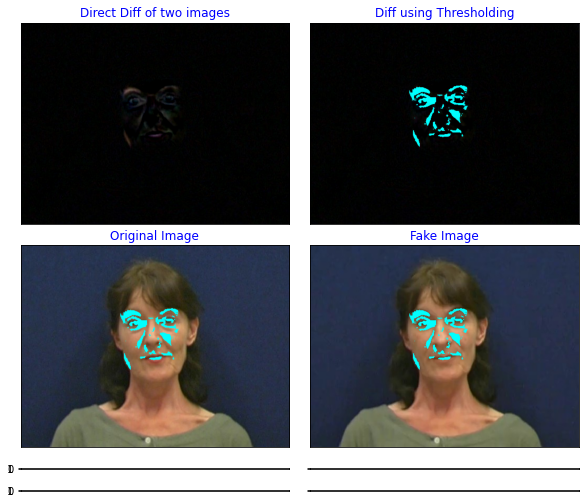

In [11]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4,2),  
                 axes_pad=0.3, 
                 )

for ax,fname,title in zip(grid, images,titles):
    # Iterating over the grid returns the Axes.
    ax.imshow(fname)
    ax.set_title(title,color='blue')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Histograms of Real and Fake Image for Frame 0

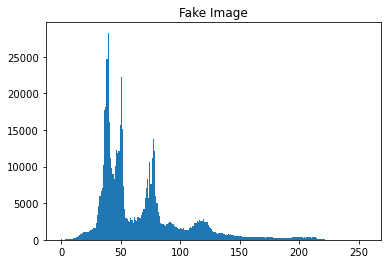

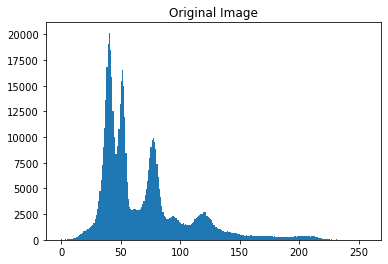

In [12]:
plt.title('Fake Image')
plt.hist(fake_image_.ravel(),256,[0,256])

plt.show()
plt.title('Original Image')
plt.hist(original_image_.ravel(),256,[0,256]); plt.show()


plt.show()

Fake Image Histogram Distribution seems to be 
1. pointy along with randomness
2. incosistent with small peaks
3. not smooth

# Face Detection

In [13]:
face_cascade = cv2.CascadeClassifier('pretrainedmodels/haarcascade_frontalface_default.xml')

img_path = 'Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg'


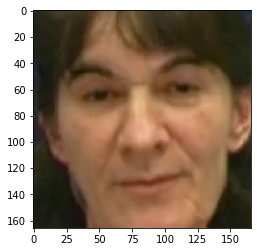

In [14]:
def face_region(img_path,model_classifier):
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    faces = model_classifier.detectMultiScale(gray, 1.1, 3)
#     print(faces)
    for (x,y,w,h) in faces:
        
#         img = cv2.rectangle(original_img,(x,y),(x+w,y+h),(255,0,0),1)
        face_cropped_color = original_img[y:y+h, x:x+w]
    return face_cropped_color,faces




face_cropped_color,face_cordinates = face_region(img_path,face_cascade)

plt.imshow(face_cropped_color)
plt.show()


### Initalizing variables for  frames

In [15]:
# all_fake_frames = glob(file_path('/'.join(fake_videos_path.split('/')[:-1]),mode='jpg'),recursive=True)
# all_original_frames = glob(file_path('/'.join(original_videos_path.split('/')[:-1]),mode='jpg'),recursive=True)
# # all_original_frames

In [16]:
# all_fake_frames_dict = {'_'.join(i.split('/')[-3:-1]):[j for j in glob(file_path(os.path.join('Dataset/DeepfakeTIMIT/Frame/**',i.split('/')[-2]),mode='jpg'),recursive=True)] for i in all_fake_frames}
# all_original_frames_dict = {'_'.join(i.split('/')[-3:-1]):[j for j in glob(file_path(os.path.join('Dataset/VidTIMIT/Frame/**',i.split('/')[-2]),mode='jpg'),recursive=True)] for i in all_original_frames}
# # all_original_frames_dict

### Cropping Faces of Fake Images and ignoring those which have no face 

In [17]:
BasePath = 'Dataset/DeepfakeTIMIT/'
FolderName='Frame'
TargetFolder = 'CroppedFaces'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]

new_dirnames = [j for j in dirnames if j not in [os.path.basename(i) for i in glob('/home/rakshit/Music/deepfakes-detection-master/Dataset/DeepfakeTIMIT/CroppedFaces/*')]]
new_dirnames.append('mrgg0')
for i in tqdm(new_dirnames):
    print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
        vide_folder_name = os.path.basename(j)
        write_path =os.path.join(BasePath,TargetFolder,i,vide_folder_name)
        os.makedirs(write_path,exist_ok=True)
        for k in glob(j+'/*'):
        #             print(k)
            frame_name = os.path.basename(k)
            try:

                face_cropped_color,face_cordinates = face_region(k,face_cascade)
                cv2.imwrite(os.path.join(write_path,f'{frame_name}'), face_cropped_color)
            except:
                print(k,'image cant detect face')
                continue


    #             cv2.imwrite(os.path.join(write_path,f'{frame_name}'), face_cropped_color)  

# filenames = glob('Dataset/DeepfakeTIMIT/CroppedFaces/mmdb1/*')

  0%|          | 0/1 [00:00<?, ?it/s]

mrgg0
Dataset/DeepfakeTIMIT/Frame/mrgg0/si1829_video_msjs1_avi/frame_85.jpg image cant detect face
Dataset/DeepfakeTIMIT/Frame/mrgg0/si1829_video_msjs1_avi/frame_57.jpg image cant detect face


100%|██████████| 1/1 [00:47<00:00, 47.27s/it]


### Cropping Faces of Original Images

In [ ]:
BasePath = 'Dataset/VidTMT/'
FolderName='Frame'
TargetFolder = 'CroppedFaces'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]

for i in tqdm(new_dirnames):
    print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
        vide_folder_name = os.path.basename(j)
        write_path =os.path.join(BasePath,TargetFolder,i,vide_folder_name)
        os.makedirs(write_path,exist_ok=True)
        for k in glob(j+'/*'):
        #             print(k)
            frame_name = os.path.basename(k)
            try:

                face_cropped_color,face_cordinates = face_region(k,face_cascade)
                cv2.imwrite(os.path.join(write_path,f'{frame_name}'), face_cropped_color)
            except:
                print(k,'image cant detect face')

## Structural Similarity in Images

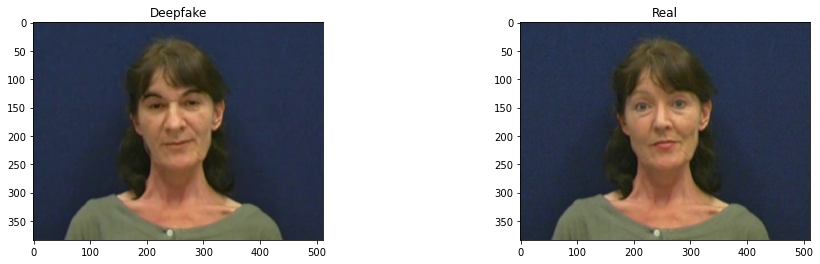

In [18]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.imshow(fake_image_)
plt.title('Deepfake')
plt.subplot(1, 2, 2)
plt.title('Real')
plt.imshow(original_image_)
plt.show()

In [19]:
assert original_image_.shape==fake_image_.shape

## Functions for structural similarity

In [20]:
def structure_similairty_images(original_image_,fake_image_):
    gray_original_image_ = cv2.cvtColor(original_image_, cv2.COLOR_BGR2GRAY)
    gray_fake_image_ = cv2.cvtColor(fake_image_, cv2.COLOR_BGR2GRAY)
    
    gray_fake_image_ = cv2.resize(gray_fake_image_, gray_original_image_.shape[:2][::-1])
    
    (similarity_score, image_difference) = structural_similarity(gray_original_image_, gray_fake_image_, full=True)
    image_difference = (image_difference * 255).astype("uint8")

#     print("Structural Similarity Index: {}".format(similarity_score))
    return image_difference,similarity_score

def plot_threshhold_diff_images(image_difference,original_image,fake_image):
    fake_image = cv2.resize(fake_image, original_image.shape[:2][::-1])
    thresh = cv2.threshold(image_difference, 0, 25,    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 0, 255), 1)
        cv2.rectangle(fake_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

    plt.figure(figsize=(16, 14))
    plt.subplot(2, 2, 1)
    plt.imshow(fake_image)
    plt.title('Deepfake')
    plt.subplot(2, 2, 2)
    plt.title('Real')
    plt.imshow(original_image)
    plt.subplot(2, 2, 3)
    plt.title('image_difference')
    plt.imshow(image_difference)


    plt.subplot(2, 2, 4)
    plt.title('thresh')
    plt.imshow(thresh)
    plt.show()

    
    

In [21]:
fake_image = cv2.imread("Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg")
original_image = cv2.imread("Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg")

fake_image = cv2.cvtColor(fake_image,cv2.COLOR_BGR2RGB)
original_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

Structure Similarity of full images

In [22]:
image_difference,similarity_score = structure_similairty_images(fake_image,original_image)

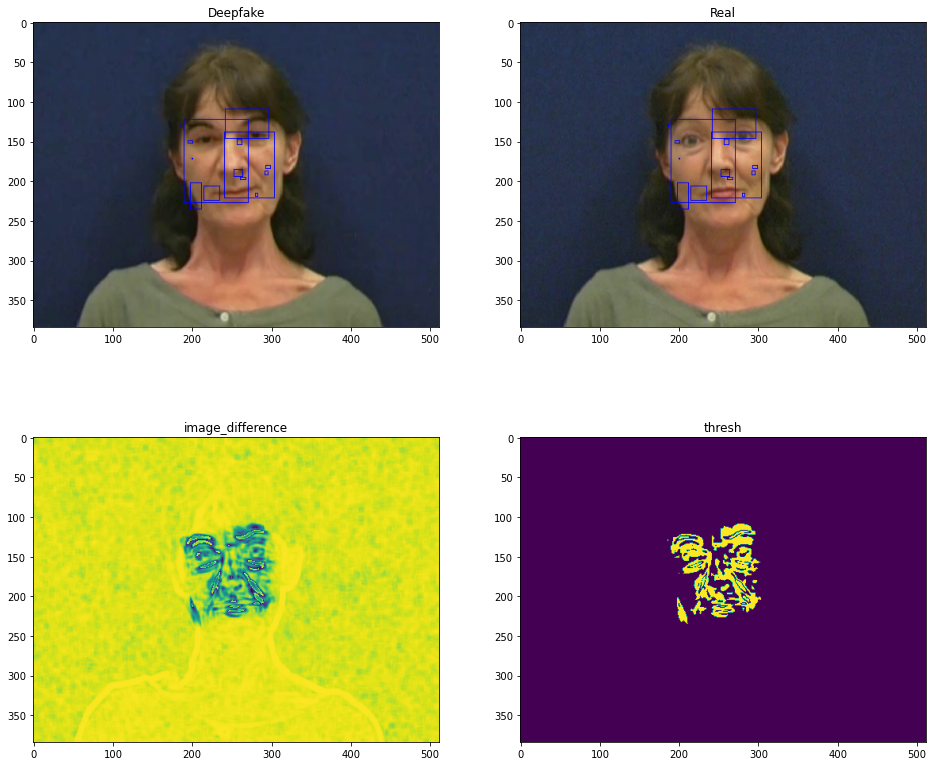

In [23]:
plot_threshhold_diff_images(image_difference,original_image,fake_image)

Structure Similarity of cropped faces

In [24]:
fake_cropped,_ = face_region('Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg',face_cascade)
original_cropped,_ = face_region('Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg',face_cascade)

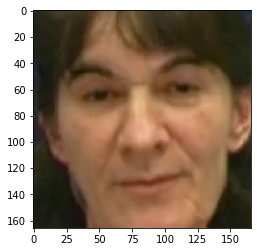

In [25]:
plt.imshow(fake_cropped)

In [26]:
image_difference,similarity_score = structure_similairty_images(fake_cropped,original_cropped)

### The major difference we observed are  diffrence in eye shapes, jawline,eyebrows, keypoints near lips

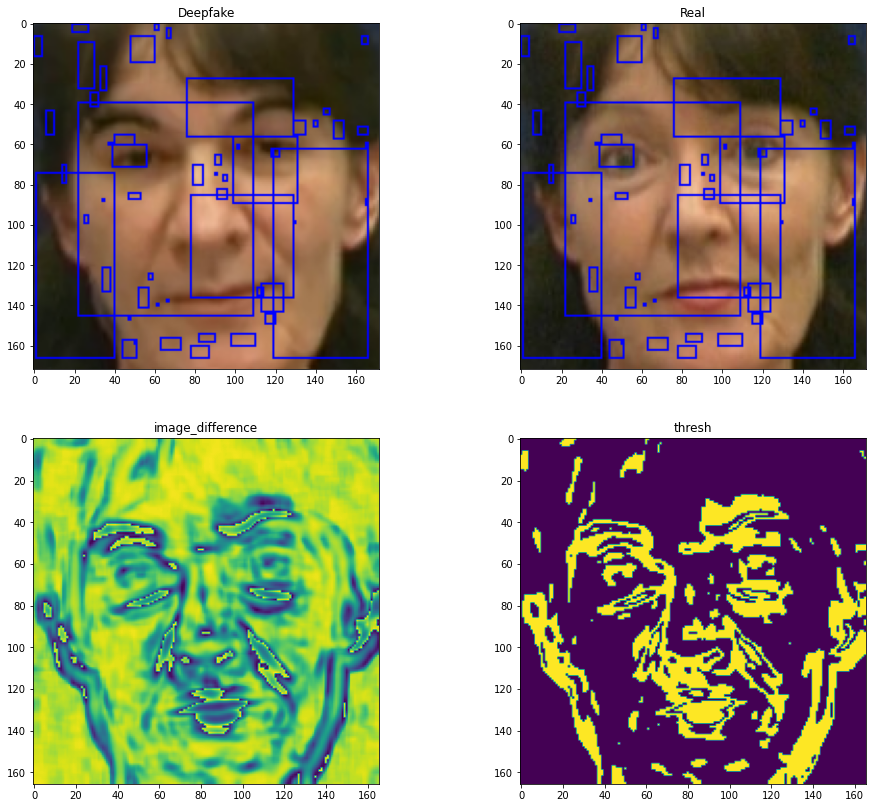

In [27]:
plot_threshhold_diff_images(image_difference,original_cropped,fake_cropped)

## Template Matching

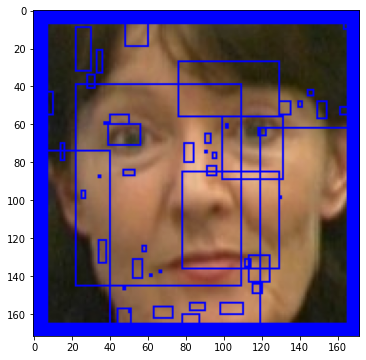

In [28]:
original_img_gray = cv2.cvtColor(original_cropped, cv2.COLOR_BGR2GRAY)
fake_image_template_gray = cv2.cvtColor(fake_cropped, cv2.COLOR_BGR2GRAY)

w, h = fake_image_template_gray.shape[::-1]

res = cv2.matchTemplate(original_img_gray,fake_image_template_gray,cv2.TM_CCOEFF_NORMED)
threshold = .8
loc = np.where( res >= threshold)
# print(len(loc[0]))
for pt in zip(*loc[::-1]):
    cv2.rectangle(original_cropped, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
plt.figure(figsize=(16, 6))
plt.imshow(original_cropped)
plt.show()

In [29]:
np.mean(res)

0.8806448

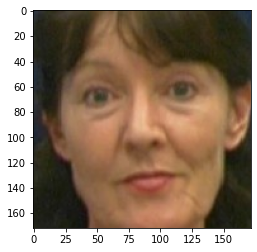

In [30]:
fake_cropped,_ = face_region('Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg',face_cascade)
original_cropped,_ = face_region('Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg',face_cascade)

plt.imshow(fake_cropped)
plt.imshow(original_cropped)

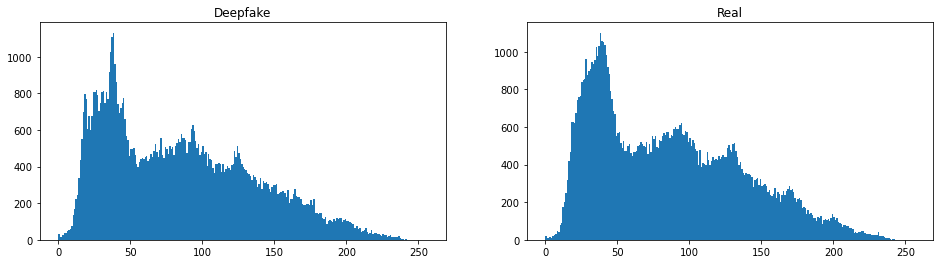

In [31]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title('Deepfake')
plt.hist(fake_cropped.ravel(),256,[0,256])

plt.subplot(1, 2, 2)
plt.title('Real')
plt.hist(original_cropped.ravel(),256,[0,256])
plt.show()

In [32]:
## Plotting histogram on the basis of rgb channels 

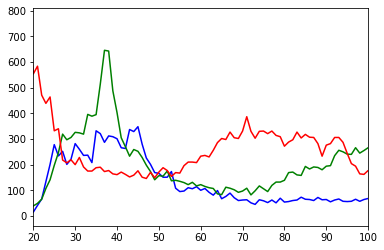

In [33]:
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([fake_cropped],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([20,100])
plt.show()

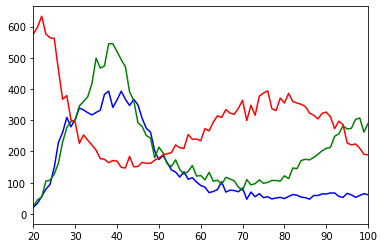

In [34]:
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([original_cropped],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([20,100])
plt.show()

##### Creating Feature Vector Functions

In [35]:
def MSE(img1, img2):
    squared_diff = (img1 -img2) ** 2
    summed = np.sum(squared_diff)
    num_pix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
    err = summed / num_pix
    return err


def PSNR(img1, img2): 
    mse = MSE(img1, img2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / np.sqrt(mse)) 
    return psnr 


def average_difference(img1 , img2):
    return np.mean(img1 - img2)

def Template_matching_mean(img1,img2):
    img_gray     = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    blurred_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    w, h = blurred_gray.shape[::-1]

    res = cv2.matchTemplate(img_gray,blurred_gray,cv2.TM_CCOEFF_NORMED)
    return np.mean(res)

def histogram_values(img_cropped,n=64):
    hist_values = np.histogram(img_cropped.ravel(),n,[0,256])[0]
    return [i/sum(hist_values) for i in hist_values ]


def combine_all_features(img,label,video_id,hist_features=64):
    features = []
    
    img_copy = copy.deepcopy(img)
    img_blurred = cv2.GaussianBlur(img,(25,25),0)
    
    mse_error = MSE(img_copy, img_blurred)
    psnr = PSNR(img_copy,img_blurred)
    ad = average_difference(img_copy,img_blurred)
    
    image_difference,similarity_score = structure_similairty_images(img,img_blurred)
    
    hist = histogram_values(img_copy,n=hist_features)
    
    features.extend([video_id,ad,mse_error,psnr,similarity_score])
    
    features.extend(hist)
    features.extend([label])
    
    return features

In [36]:
fake_cropped,_ = face_region('Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg',face_cascade)
original_cropped,_ = face_region('Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg',face_cascade)

####  Choosing Kernel size for Gaussain Kernel =13,13 , Greater the kernel size and greater the blurriness, and hence mse will not be that different for orginal and fake images

#### MSE

61.9564886050225


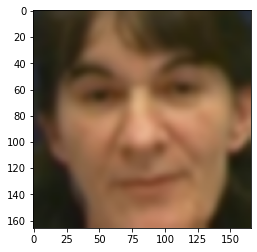

67.02271498107085


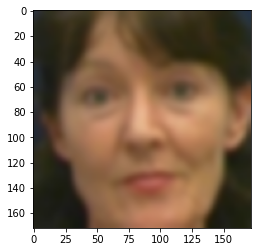

In [37]:
j=(13,13)
fake_blurred =  cv2.GaussianBlur(fake_cropped,j,0)
print(MSE(fake_cropped,fake_blurred))
plt.imshow(fake_blurred)
plt.show()
original_blurred =  cv2.GaussianBlur(original_cropped,j,0)
print(MSE(original_cropped,original_blurred))
plt.imshow(original_blurred)

### PSNR

In [38]:
print('fake_cropped : ', PSNR(fake_cropped, fake_blurred))
print('original_cropped : ', PSNR(original_cropped, original_blurred))

fake_cropped :  30.20993564800044
original_cropped :  29.868583444498952


### Structural Similarity

In [39]:
image_difference,similarity_score = structure_similairty_images(fake_cropped,fake_blurred)
image_difference,similarity_score = structure_similairty_images(original_cropped,original_blurred)

In [40]:
print(Template_matching_mean(fake_cropped,fake_blurred))
print(Template_matching_mean(original_cropped,original_blurred))

0.9921423
0.9909414


30.0


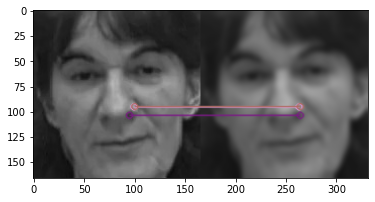

In [41]:
fake_cropped,_ = face_region('Dataset/DeepfakeTIMIT/Frame/fadg0/sa1_video_fram1_avi/frame_0.jpg',face_cascade)

fake_cropped = cv2.cvtColor(fake_cropped,cv2.COLOR_BGR2GRAY)
fake_blurred =  cv2.GaussianBlur(fake_cropped,j,0)
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(fake_cropped,None)
kp2, des2 = orb.detectAndCompute(fake_blurred,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)
print(matches[0].distance)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(fake_cropped,kp1,fake_blurred,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

In [42]:
original_cropped,_ = face_region('Dataset/VidTIMIT/Frame/fadg0/sa1_avi/frame_0.jpg',face_cascade)
original_blurred = cv2.GaussianBlur(original_cropped,(13,13),0)

In [43]:
# plt.imshow(fake_cropped)
fake_cropped.shape

(166, 166)

### Saving features numpy in H5py format

In [45]:
# hf = h5py.File('data3.h5', 'w')
# hf.create_dataset('dataset_1', data=fake_frame_features)
# hf.close()

In [46]:
# hf = h5py.File('data3.h5', 'r')
# n1 = hf.get('dataset_1')
# n1 = np.array(n1)
# n1.shape
# n1

## Saving Features for one complete video in 1 h5py file

In [81]:
hf.close()

In [82]:
BasePath = 'Dataset/DeepfakeTIMIT/'
FolderName='CroppedFaces'
TargetFolder = 'Features'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]

vid_names_dict={}
vid_names_dict['base']=1

for i in tqdm(dirnames):
    print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
#         print(j)
        vide_folder_name = os.path.basename(j)
        write_path =os.path.join(BasePath,TargetFolder,i)
        os.makedirs(write_path,exist_ok=True)
        feature_list=[]
        vid_names_dict[str(vide_folder_name)]=max(vid_names_dict.values())+1
        for k in glob(j+'/*'):
#             print(k)
            frame_name = os.path.basename(k)
            image = cv2.imread(k)
            
            fake_frame_features = combine_all_features(image,0,vid_names_dict[str(vide_folder_name)])
#             print(os.path.join(write_path,vide_folder_name+'.h5'))
            feature_list.append(fake_frame_features)
        hf = h5py.File(os.path.join(write_path,vide_folder_name+'.h5'), 'w')
        hf.create_dataset('dataset', data=feature_list)
        hf.close()

  0%|          | 0/32 [00:00<?, ?it/s]

mmdb1


  3%|▎         | 1/32 [00:07<03:44,  7.25s/it]

mdab0


  6%|▋         | 2/32 [00:16<03:53,  7.78s/it]

mwbt0


  9%|▉         | 3/32 [00:25<04:00,  8.29s/it]

felc0


 12%|█▎        | 4/32 [00:31<03:29,  7.49s/it]

mmdm2


 16%|█▌        | 5/32 [00:37<03:08,  6.98s/it]

fjem0


 19%|█▉        | 6/32 [00:46<03:19,  7.67s/it]

mccs0


 22%|██▏       | 7/32 [00:52<03:03,  7.34s/it]

fdac1


 25%|██▌       | 8/32 [00:58<02:44,  6.85s/it]

fdrd1


 28%|██▊       | 9/32 [01:04<02:31,  6.60s/it]

fjre0


 31%|███▏      | 10/32 [01:10<02:19,  6.35s/it]

msjs1


 34%|███▍      | 11/32 [01:18<02:23,  6.84s/it]

mdbb0


 38%|███▊      | 12/32 [01:24<02:14,  6.71s/it]

fcft0


 41%|████      | 13/32 [01:31<02:05,  6.59s/it]

fedw0


 44%|████▍     | 14/32 [01:37<01:56,  6.45s/it]

fjas0


 47%|████▋     | 15/32 [01:42<01:45,  6.19s/it]

fadg0


 50%|█████     | 16/32 [01:48<01:38,  6.13s/it]

mjar0


 53%|█████▎    | 17/32 [01:57<01:42,  6.81s/it]

mrgg0


 56%|█████▋    | 18/32 [02:10<02:01,  8.66s/it]

faks0


 59%|█████▉    | 19/32 [02:15<01:40,  7.76s/it]

mrcz0


 62%|██████▎   | 20/32 [02:22<01:27,  7.29s/it]

mpdf0


 66%|██████▌   | 21/32 [02:28<01:16,  6.95s/it]

mpgl0


 69%|██████▉   | 22/32 [02:33<01:04,  6.40s/it]

fcmh0


 72%|███████▏  | 23/32 [02:39<00:56,  6.23s/it]

mcem0


 75%|███████▌  | 24/32 [02:44<00:48,  6.03s/it]

fkms0


 78%|███████▊  | 25/32 [02:50<00:42,  6.00s/it]

fjwb0


 81%|████████▏ | 26/32 [02:57<00:37,  6.30s/it]

mrjo0


 84%|████████▍ | 27/32 [03:04<00:32,  6.47s/it]

fram1


 88%|████████▊ | 28/32 [03:11<00:26,  6.53s/it]

mstk0


 91%|█████████ | 29/32 [03:17<00:19,  6.56s/it]

mgwt0


 94%|█████████▍| 30/32 [03:24<00:13,  6.71s/it]

mdld0


 97%|█████████▋| 31/32 [03:32<00:06,  6.95s/it]

mjsw0


100%|██████████| 32/32 [03:37<00:00,  6.81s/it]


322

In [149]:
real_vid_names_dict={}
real_vid_names_dict['base']=max(vid_names_dict.values())+1

In [150]:
BasePath = 'Dataset/VidTIMIT/'
FolderName='CroppedFaces'
TargetFolder = 'Features'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]


for i in tqdm(dirnames):
    print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
#         print(j)
        vide_folder_name = os.path.basename(j)
        write_path =os.path.join(BasePath,TargetFolder,i)
        os.makedirs(write_path,exist_ok=True)
        feature_list=[]
        real_vid_names_dict[str(vide_folder_name)]=max(real_vid_names_dict.values())+1
        for k in glob(j+'/*'):
#             print(k)
            
            frame_name = os.path.basename(k)
            image = cv2.imread(k)
            fake_frame_features = combine_all_features(image,1,real_vid_names_dict[str(vide_folder_name)])

            feature_list.append(fake_frame_features)
        hf = h5py.File(os.path.join(write_path,vide_folder_name+'.h5'), 'w')
        hf.create_dataset('dataset', data=feature_list)
        hf.close()

  0%|          | 0/32 [00:00<?, ?it/s]

mmdb1


  3%|▎         | 1/32 [00:07<03:46,  7.32s/it]

mdab0


  6%|▋         | 2/32 [00:16<03:54,  7.81s/it]

mwbt0


  9%|▉         | 3/32 [00:24<03:48,  7.89s/it]

felc0


 12%|█▎        | 4/32 [00:30<03:29,  7.47s/it]

mmdm2


 16%|█▌        | 5/32 [00:36<03:10,  7.06s/it]

fjem0


 19%|█▉        | 6/32 [00:45<03:14,  7.48s/it]

mccs0


 22%|██▏       | 7/32 [00:52<03:00,  7.22s/it]

fdac1


 25%|██▌       | 8/32 [00:57<02:40,  6.69s/it]

fdrd1


 28%|██▊       | 9/32 [01:03<02:26,  6.38s/it]

fjre0


 31%|███▏      | 10/32 [01:11<02:34,  7.01s/it]

msjs1


 34%|███▍      | 11/32 [01:19<02:34,  7.37s/it]

mdbb0


 38%|███▊      | 12/32 [01:26<02:21,  7.10s/it]

fcft0


 41%|████      | 13/32 [01:32<02:12,  6.98s/it]

fedw0


 44%|████▍     | 14/32 [01:39<02:03,  6.88s/it]

fjas0


 47%|████▋     | 15/32 [01:47<02:03,  7.24s/it]

fadg0


 50%|█████     | 16/32 [01:53<01:49,  6.85s/it]

mjar0


 53%|█████▎    | 17/32 [02:01<01:47,  7.15s/it]

mrgg0


 56%|█████▋    | 18/32 [02:14<02:04,  8.90s/it]

faks0


 59%|█████▉    | 19/32 [02:21<01:47,  8.28s/it]

mrcz0


 62%|██████▎   | 20/32 [02:28<01:37,  8.09s/it]

mpdf0


 66%|██████▌   | 21/32 [02:36<01:26,  7.88s/it]

mpgl0


 69%|██████▉   | 22/32 [02:41<01:11,  7.14s/it]

fcmh0


 72%|███████▏  | 23/32 [02:47<00:59,  6.64s/it]

mcem0


 75%|███████▌  | 24/32 [02:52<00:50,  6.32s/it]

fkms0


 78%|███████▊  | 25/32 [02:58<00:43,  6.22s/it]

fjwb0


 81%|████████▏ | 26/32 [03:05<00:38,  6.34s/it]

mrjo0


 84%|████████▍ | 27/32 [03:11<00:32,  6.40s/it]

fram1


 88%|████████▊ | 28/32 [03:18<00:25,  6.41s/it]

mstk0


 91%|█████████ | 29/32 [03:24<00:19,  6.44s/it]

mgwt0


 94%|█████████▍| 30/32 [03:33<00:14,  7.01s/it]

mdld0


 97%|█████████▋| 31/32 [03:40<00:07,  7.04s/it]

mjsw0


100%|██████████| 32/32 [03:45<00:00,  7.06s/it]


#### Extracting all filenames with their path in a list

In [151]:
BasePath = 'Dataset/VidTIMIT/'
FolderName='Features'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]

VidTIMIT_files=[]
for i in tqdm(dirnames):
#     print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
        VidTIMIT_files.append(j)

100%|██████████| 32/32 [00:00<00:00, 5422.94it/s]


In [152]:
BasePath = 'Dataset/DeepfakeTIMIT/'
FolderName='Features'

dirnames_lst = glob(BasePath+FolderName+'/*')
dirnames = [os.path.basename(os.path.join(i)) for i in dirnames_lst]

DeepfakeTIMIT_files=[]
for i in tqdm(dirnames):
#     print(i)
    for j in (glob(os.path.join(BasePath,FolderName,i,'*'))):
        DeepfakeTIMIT_files.append(j)

100%|██████████| 32/32 [00:00<00:00, 6014.42it/s]


### Creating Partition Function to shuffle and rearrange the files to make train and test list

In [153]:
import numpy as np

def partition(files,percent = 0.8):
    files = np.array(files)
    train_len = int(len(files)*percent)
    indices = np.random.permutation(len(files))
    training_idx, test_idx = indices[:train_len], indices[train_len:]
    training = [files[i] for i in training_idx]
    test =[files[i] for i in test_idx]
    return training,test

In [154]:
VidTIMIT_training,VidTIMIT_test = partition(VidTIMIT_files)
DeepfakeTIMIT_training,DeepfakeTIMIT_test = partition(DeepfakeTIMIT_files)

In [155]:
training_dataset = VidTIMIT_training + DeepfakeTIMIT_training
test_dataset = VidTIMIT_test + DeepfakeTIMIT_test

In [156]:
len(test_dataset)

128

In [157]:
len(training_dataset)

512

### Rading all h5py files together to create one single train and test file

In [158]:
train = np.vstack([np.array(h5py.File(training_dataset[x], 'r').get('dataset')) for x in np.random.permutation(len(training_dataset))])
test = np.vstack([np.array(h5py.File(test_dataset[x], 'r').get('dataset')) for x in np.random.permutation(len(test_dataset))])

In [159]:
train.shape

(27167, 70)

In [160]:
test.shape

(7012, 70)

### Saving Unique video id's and their labels

In [185]:
import pandas as pd
train_unique_df = pd.DataFrame(train[:,[0,-1]],columns=['image_id','label']).drop_duplicates().sort_values('image_id')
test_unique_df = pd.DataFrame(test[:,[0,-1]],columns=['image_id','label']).drop_duplicates().sort_values('image_id')


### Image Names

In [186]:
X_train_imageName = train[:,:1]
X_test_imageName = test[:,:1]

### Seperating Labels and dataset

In [187]:
X_train, y_train = train[:,1:-1] , train[:,-1]
X_test, y_test = test[:,1:-1] , test[:,-1]

### Imlementing SVM classifier with Linear Kernel

In [189]:
def model_fit(kernel_name,X_train,y_train,X_test,y_test,degree_poly=2):
    if kernel_name=='poly':
        print(f'----------------For Kernel {kernel_name} and degree {degree_poly}--------------------------')
        svclassifier = SVC(kernel='poly', degree=degree_poly,probability=True)
    else:
        print(f'----------------For Kernel {kernel_name} --------------------------')
        svclassifier = SVC(kernel=kernel_name,probability=True)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict_proba(X_test)
    results = pd.DataFrame(np.vstack([test[:,0],y_pred[:,1]])).T
    results.columns=['id','res']
    results = results.groupby(['id'])['res'].mean().reset_index()
    results['final_ans'] = results['res']>.5
    results['final_ans']=results['final_ans'].astype('int')
    print(confusion_matrix(test_unique_df['label'].values,results['final_ans'].values))
    print(classification_report(test_unique_df['label'].values,results['final_ans'].values))
    cm = confusion_matrix(test_unique_df['label'].values,results['final_ans'].values)
    print(f'Error Rate(ERR): {(cm[0,1]+cm[1,0])/sum(sum(cm))} (0 is best and 1 is worst)')

### Implementing Poly ,rbf and sigmoid kernel

In [190]:
for different_kernels in ['linear','rbf','sigmoid','poly']:
    if different_kernels=='poly':
        for i in range(2,10):
            model_fit(different_kernels,X_train,y_train,X_test,y_test,degree_poly=i)
    else:
        model_fit(different_kernels,X_train,y_train,X_test,y_test)
              
    

----------------For Kernel linear --------------------------
[[57  7]
 [ 3 61]]
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92        64
         1.0       0.90      0.95      0.92        64

    accuracy                           0.92       128
   macro avg       0.92      0.92      0.92       128
weighted avg       0.92      0.92      0.92       128

Error Rate(ERR): 0.078125 (0 is best and 1 is worst)
----------------For Kernel rbf --------------------------
[[52 12]
 [ 5 59]]
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86        64
         1.0       0.83      0.92      0.87        64

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.87      0.87      0.87       128

Error Rate(ERR): 0.1328125 (0 is best and 1 is worst)
----------------For Kernel sigmoid --------------------------
[[34 30]
 [30 34]]
 

#### Linear Kernel Outperformed all with f1 score of 92 % with ERR of 0.07%